In [1]:
!pip install  mysql-connector-python

In [2]:
import time
import numpy as np 

In [3]:
import mysql.connector

conn = mysql.connector.connect(
    #database="climadb-master",
    user="",
    password="", 
    host=".rds.amazonaws.com",
    port="3306"
)

In [4]:
cursor = conn.cursor()

In [5]:
#cursor.execute("CREATE DATABASE clima_database")
cursor.execute("USE clima_integra")  
cursor.execute("SELECT COUNT(*) FROM DWDtest1 ")
print(f"DWD CARDIHNALITY: {cursor.fetchall()}")

DWD CARDIHNALITY: [(720,)]


In [6]:
cursor.fetchall()
cursor.execute("DESCRIBE DWD")
columns = cursor.fetchall()

# Extract column names
column_names = [column[0] for column in columns]
print(column_names)

['id', 'station_id', 'datetime', 'name', 'lattitude', 'longitude', 'height', 'wind_speed', 'wind_direct', 'temp', 'humidity', 'prec_mm', 'prec_form', 'sun_dur', 'cloudy', 'extreme_wind_speed', 'humidity_abs', 'temp_wet_bulb', 'pres_sealvl', 'pres', 'soil_temp_5', 'soil_temp_10', 'soil_temp_20', 'soil_temp_50', 'soil_temp_100']


In [7]:
import boto3

# Create a Timestream Query client
timestream_query_client = boto3.client('timestream-query')

In [8]:
def tq (q, dtype, verbose = True):
    
    # Query to describe the table
    query_response = timestream_query_client.query(
        QueryString=q
    )

    # Extract the column names
    answer = [row['Data'][0][dtype] for row in query_response['Rows']]
    #answer = query_response['Rows']['Data']
    answer = np.array(answer)
    
    if verbose:
        print(answer)
    return answer

answer = tq('DESCRIBE "myclimab"."clima-integra"', dtype = 'ScalarValue')

['latt' 'name' 'long' 'height' 'measure_name' 'time' 'TT_TU' 'ABSF_STD'
 'RF_TU' 'TF_STD' 'R1' 'P0' 'V_TE020' 'V_TE010' 'V_TE100' 'V_N' 'V_TE050'
 'V_TE005' 'P' 'WRTR' 'FX_911' 'SD_SO' 'D' 'F']


In [9]:
answer = tq('SELECT COUNT(*) FROM "myclimab"."clima-integra"', dtype='ScalarValue')
print(f"Cardinality: {answer}")

['720']
Cardinality: ['720']


### Experiment condition 1: monitoring

In [13]:
#MySQL: max of the latest
import random

monitoring_vars = ['prec_mm','extreme_wind_speed','humidity_abs','temp_wet_bulb' ,'pres']
timer_SQL_1_1 =[]
i = 0
query = """
    WITH cte AS (
        SELECT 
            station_id, 
            (SELECT MAX(datetime) 
            FROM DWD 
            WHERE station_id = d.station_id AND {0} IS NOT NULL) AS dt_v1
        FROM DWD d
        GROUP BY station_id
    )
    SELECT 
        data.station_id,
        data.{0}
    FROM DWD AS data
    RIGHT JOIN cte ON (cte.dt_v1 = data.datetime AND cte.station_id = data.station_id)
    ORDER BY data.{0} DESC
    LIMIT 1
"""
# we run it only once,as it appeared to be a vary slow query
while i < 1:
    v1 = random.choice(monitoring_vars)
    start_time = time.time()

    cursor.execute(query.format(v1))
    end_time = time.time()
    monitoring_result = cursor.fetchall()
    execution_time = end_time - start_time
    #print(f"a result with max {v1} is station, value: {monitoring_result}")
    timer_SQL_1_1.append(execution_time)
    i += 1

In [14]:
cursor.fetchall()

[]

In [15]:
# MySQL: the latest max data overall (na-friendly) and maximal station observation
monitoring_vars = ['prec_mm','extreme_wind_speed','humidity_abs','temp_wet_bulb' ,'pres']

timer_SQL_1_2 = []
query = """
    SELECT station_id, {0}
    FROM DWD
    WHERE datetime = (SELECT MAX(datetime) FROM DWD)
    ORDER BY {0} DESC
    LIMIT 1
"""
for _ in range(80):
    v1 = random.choice(monitoring_vars)
    start_time = time.time()

    cursor.execute(query.format(v1))
    end_time = time.time()
    monitoring_result = cursor.fetchall()
    execution_time = end_time - start_time
    #print(f"warning, station with max {v1} is {monitoring_result}")
    timer_SQL_1_2.append(execution_time)

In [16]:
# timestream: the latest actual observation
monitoring_vars = ['P0','TT_TU','RF_TU','R1','ABSF_STD']
# Create a Timestream Query client
timestream_query_client = boto3.client('timestream-query')
timer_TS_1_1 =[]
query_template = '''
    WITH latest_records AS (
        SELECT 
            name,
            max_by({0}, time) AS latest_v1
        FROM "myclimab"."clima-integra"
        GROUP BY name
    )
    SELECT 
        name,
        latest_v1
    FROM latest_records
    WHERE latest_v1 = (SELECT max(latest_v1) FROM latest_records)
'''

for _ in range(80):
    v1 = random.choice(monitoring_vars)
    start_time = time.time()
    query_response = timestream_query_client.query(
        QueryString=query_template.format(v1)
    )
    end_time = time.time()
    execution_time = end_time - start_time
    timer_TS_1_1.append(execution_time)

# Extract the query results
query1 = [row['Data'] for row in query_response['Rows']]

print(query1)

[[{'ScalarValue': 'Airport-Berlin-Brandenburg'}, {'ScalarValue': '1001.0'}]]


In [17]:
# Timestream: the latest data overall (na-friendly) and the max station
monitoring_vars = ['P0','TT_TU','RF_TU','R1','ABSF_STD']

timer_TS_1_2 = []
query_template = '''
    WITH latest_time AS (
        SELECT 
            max(time) AS latest_time
        FROM "myclimab"."clima-integra"
    )
    
    SELECT 
            name,
            {0} AS max_v1
        FROM "myclimab"."clima-integra"
        WHERE time = (SELECT latest_time FROM latest_time)
        ORDER BY max_v1 DESC
        LIMIT 1    
'''
for _ in range(80):
    v1 = random.choice(monitoring_vars)
    start_time = time.time()
    query_response = timestream_query_client.query(
        QueryString=query_template.format(v1)
    )
    end_time = time.time()
    execution_time = end_time - start_time
    timer_TS_1_2.append(execution_time)

# Extract the query results
query1 = [row['Data'] for row in query_response['Rows']]

print(query1 , "for variable ",v1)

[[{'ScalarValue': 'Berlin-Dahlem-FU'}, {'ScalarValue': '6.3'}]] for variable  ABSF_STD


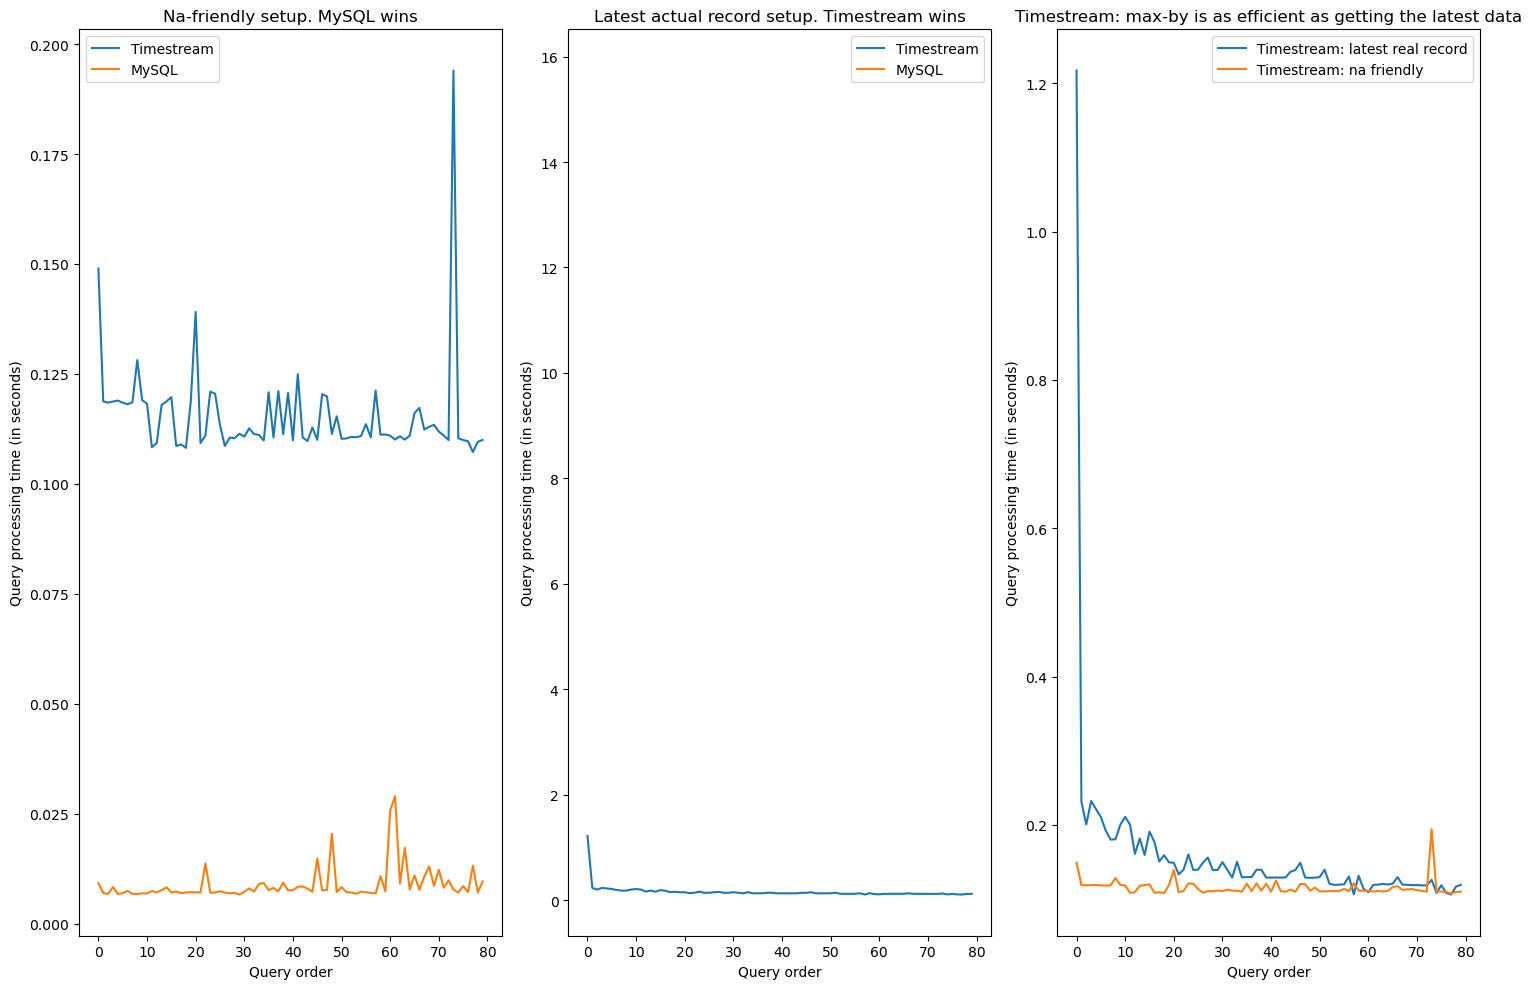

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# Subplot 1
axs[0].plot(timer_TS_1_2, label='Timestream')
axs[0].plot(timer_SQL_1_2, label='MySQL')
axs[0].set_title('Na-friendly setup. MySQL wins')
axs[0].set_xlabel('Query order')
axs[0].set_ylabel('Query processing time (in seconds)')
axs[0].legend()

# Subplot 2
axs[1].plot(timer_TS_1_1, label='Timestream')
axs[1].plot(timer_SQL_1_1, label='MySQL')
axs[1].set_title('Latest actual record setup. Timestream wins')
axs[1].set_xlabel('Query order')
axs[1].set_ylabel('Query processing time (in seconds)')
axs[1].legend()

# Subplot 3
axs[2].plot(timer_TS_1_1, label='Timestream: latest real record')
axs[2].plot(timer_TS_1_2, label='Timestream: na friendly')
axs[2].set_title('Timestream: max-by is as efficient as getting the latest data')
axs[2].set_xlabel('Query order')
axs[2].set_ylabel('Query processing time (in seconds)')
axs[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Remove the first element from timest_timer
timest_timer_adj = timer_TS_1_1[1:]

# Generate x values
x = np.arange(len(timest_timer_adj))

# Fit a polynomial of degree 1 to the data
coefficients = np.polyfit(x, timest_timer_adj, 1)

# Create a polynomial function
polynomial = np.poly1d(coefficients)

# Generate y values for the fitted line
y_fit = polynomial(x)

# Plot the original data
plt.plot(timest_timer_adj, label='Original data')

# Plot the fitted line
plt.plot(x, y_fit, color='orange', label='Fitted line')

# Add a legend
plt.legend()
plt.title('Timestream: latency decrease. Linear model')
plt.figtext(0.5, 0.01, 'Query number 1 omitted as outlier', ha='center', va='center')
plt.xlabel('Query order')
plt.ylabel('Latency')
# Show the plot
plt.show()

In [ ]:
plt.plot(timer)
plt.title('MySQL: dispersion increases from query to query')
plt.xlabel('Query order')
plt.ylabel('Latency')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the bin edges
bins = np.linspace(min(min(timer), min(timest_timer)), max(max(timer), max(timest_timer)), 21)

# Create a histogram
plt.hist(timer, bins=bins, edgecolor='black', color='blue', label='MySQL')
plt.hist(timest_timer, bins=bins, edgecolor='black', color='orange', label='Timestream')

# Add title and labels
plt.title('Histogram of Execution Times for the purpose of monitoring')
plt.xlabel('Execution Time (seconds)')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()

task 2: find the hottest soil in germany. for 2 stations with highest median temp output all soil temperatures for 5 days 
task 2.5 binned by 6 hours

In [ ]:
monitoring_vars = ["V_TE002",'V_TE005','V_TE010','V_TE020','V_TE050','V_TE100']
# Create a Timestream Query client
# BIN(time, 10m) AS binnedTime
timer_TS_2_1 =[]
query = '''
SELECT              
V_TE005,        
V_TE010,       
V_TE020,
V_TE050,              
V_TE100,
name,
time 
FROM "myclimab"."clima-integra"
WHERE time BETWEEN ago(10d) AND ago(5d)
	AND measure_name = 'soil_temperature'
	
	AND name IN (
		SELECT name
		FROM "myclimab"."clima-integra"
		GROUP BY name
		ORDER BY avg(TT_TU) ASC
			,name LIMIT 2
		)
'''
for _ in range(80):
    
    start_time = time.time()
    query_response = timestream_query_client.query(
            QueryString=query
        )
    end_time = time.time()
    execution_time = end_time - start_time
    timer_TS_2_1.append(execution_time)

# Extract the query results
#query1 = [row['Data'] for row in query_response['Rows']]

In [ ]:
# First query to get the top 2 names
query1 = '''
    SELECT name
    FROM "myclimab"."clima-integra"
    GROUP BY name
    ORDER BY avg(TT_TU) ASC
    LIMIT 2
'''

response1 = timestream_query_client.query(QueryString=query1)
top_names = [row['Data'][0]['ScalarValue'] for row in response1['Rows']]

# Second query using the result of the first query
query2 = f'''
    SELECT V_TE005, V_TE010, V_TE020, V_TE050, V_TE100, name, time
    FROM "myclimab"."clima-integra"
    WHERE time BETWEEN ago(10d) AND ago(5d)
    AND measure_name = 'soil_temperature'
    AND name IN ({", ".join(["'" + name + "'" for name in top_names])})
'''
response1 = timestream_query_client.query(QueryString=query1)
top_names = [row['Data'][0]['ScalarValue'] for row in response1['Rows']]

timer_TS_2_2 = []

for i in range(80):
    start_time = time.time()
    
    # On the very first iteration execute this
    if i == 0:
        response1 = timestream_query_client.query(QueryString=query1)
        top_names = [row['Data'][0]['ScalarValue'] for row in response1['Rows']]
    
    # Go further as planned
    query_response = timestream_query_client.query(QueryString=query2)
    
    end_time = time.time()
    execution_time = end_time - start_time
    timer_TS_2_2.append(execution_time)

In [ ]:
# Create a temporary table
cursor.execute('''
    CREATE TEMPORARY TABLE temp_table AS
    SELECT name
    FROM DWD
    GROUP BY name
    ORDER BY AVG(temp) ASC, name
    LIMIT 2
''')

# Execute the main query
query = '''
    SELECT 
        soil_temp_5 ,
        soil_temp_10 ,
        soil_temp_20 ,
        soil_temp_50 ,
        soil_temp_100, 
        name,
        datetime
    FROM DWD
    WHERE datetime BETWEEN DATE_SUB(NOW(), INTERVAL 10 DAY) 
                            AND DATE_SUB(NOW(), INTERVAL 5 DAY)
    AND name IN (SELECT name FROM temp_table)
'''

timer_SQL_2_1 = []
for _ in range(80):
    start_time = time.time()
    cursor.execute(query)
    end_time = time.time()
    monitoring_result = cursor.fetchall()
    execution_time = end_time - start_time
    #print(monitoring_result)
    timer_SQL_2_1.append(execution_time)

# Drop the temporary table
cursor.execute('DROP TABLE temp_table')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot timest_timer2
plt.plot(timer_TS_2_1, label='timestream_cte')

# Plot timest_timer3
plt.plot(timer_TS_2_2, label='timest_separate_queries')

plt.plot(timer_SQL_2_1, label='mysql_temporary_table')

plt.xlabel('Iteration')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time of Queries to retrieve time series')
plt.legend()

plt.show()

### experiment 2 with binned time

In [ ]:
# Create a temporary table
cursor.execute('''
    CREATE TEMPORARY TABLE temp_table AS
    SELECT name
    FROM DWD
    GROUP BY name
    ORDER BY AVG(temp) ASC, name
    LIMIT 2
''')

query = '''
    SELECT 
        AVG(soil_temp_5) AS avg_soil_temp_5,
        AVG(soil_temp_10) AS avg_soil_temp_10,
        AVG(soil_temp_20) AS avg_soil_temp_20,
        AVG(soil_temp_50) AS avg_soil_temp_50,
        AVG(soil_temp_100) AS avg_soil_temp_100,
        name,
        FROM_UNIXTIME(FLOOR(UNIX_TIMESTAMP(datetime)/(6*60*60))*(6*60*60)) AS binnedDatetime
    FROM DWD
    WHERE datetime BETWEEN DATE_SUB(NOW(), INTERVAL 10 DAY) AND DATE_SUB(NOW(), INTERVAL 5 DAY)
    AND name IN (SELECT name FROM temp_table)
    GROUP BY name, binnedDatetime
'''
timer_SQL_25_1 = []
for _ in range(80):
    start_time = time.time()
    cursor.execute(query)
    end_time = time.time()
    monitoring_result = cursor.fetchall()
    execution_time = end_time - start_time
    print(monitoring_result)
    timer_SQL_2_1.append(execution_time)

# Drop the temporary table
cursor.execute('DROP TABLE temp_table')

In [ ]:
query = '''
SELECT              
AVG(V_TE005) AS avg_V_TE005,        
AVG(V_TE010) AS avg_V_TE010,       
AVG(V_TE020) AS avg_V_TE020,
AVG(V_TE050) AS avg_V_TE050,              
AVG(V_TE100) AS avg_V_TE100,
name,
BIN(time, 6h) AS binnedTime
FROM "myclimab"."clima-integra"
WHERE time BETWEEN ago(10d) AND ago(5d)
    AND measure_name = 'soil_temperature'
    
    AND name IN (
        SELECT name
        FROM "myclimab"."clima-integra"
        GROUP BY name
        ORDER BY avg(TT_TU) ASC
            ,name LIMIT 2
        )
GROUP BY name, binnedTime
'''
monitoring_vars = ["V_TE002",'V_TE005','V_TE010','V_TE020','V_TE050','V_TE100']
# Create a Timestream Query client
# BIN(time, 10m) AS binnedTime
timer_TS_25_1 =[]

#do 30 times
for _ in range(80):
    
    start_time = time.time()
    query_response = timestream_query_client.query(
            QueryString=query
        )
    end_time = time.time()
    execution_time = end_time - start_time
    timer_TS_25_1.append(execution_time)

# Extract the query results
#query1 = [row['Data'] for row in query_response['Rows']]

In [ ]:
import boto3
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Create a Timestream Write client
timestream_write_client = boto3.client('timestream-write')

# Specify your database name
database_name = 'myclimab'
table_name = 'first'
# List all tables in the database
tables = timestream_write_client.list_tables(DatabaseName=database_name)

for table in tables['Tables']:
    table_name = table['TableName']

    # Create a Timestream Query client
    timestream_query_client = boto3.client('timestream-query')

    # Query the table to get the cardinality
    cardinality_query = f"SELECT COUNT(*) FROM {database_name}.{table_name}"
    cardinality_response = timestream_query_client.query(QueryString=cardinality_query)
    cardinality = cardinality_response['Rows'][0]['Data'][0]['ScalarValue']

    print(f"Table: {table_name}, Cardinality: {cardinality}")
